In [1]:
import numpy as np
import cv2
import random
import pandas as pd
import time

import matplotlib.pyplot as plt
from seaborn import load_dataset

In [2]:
path= '../../Alejandro_Proyectos/'
pathReferencia ='Imagenes Originales Gris/lena_gray.png'
pathRuido='lena/lena_gray_512_512_variance_100.png'
imagenReferencia = cv2.imread(path+pathReferencia)
imagenReferenciaGris = cv2.cvtColor(imagenReferencia, cv2.COLOR_RGB2GRAY)
imagenRuido = cv2.imread(path+pathRuido)
imagenRuidoGris = cv2.cvtColor(imagenRuido, cv2.COLOR_RGB2GRAY)
areaBusqueda = 21
tamañoParche = 8
split_punto = pathRuido.split(".")
split_guion = split_punto[0].split("_")
varianzaOriginal = int(split_guion[len(split_guion)-1])

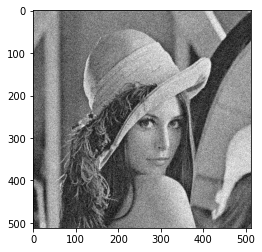

In [3]:
plt.imshow(cv2.cvtColor(imagenRuidoGris, cv2.COLOR_BGR2RGB))
plt.show()

# Algoritmo de Busqueda Jerarquica con transformada Fourier

In [4]:
def transformadaFourier(img1):
    img1_Fourier = img1.astype('float')
    #print(img1_Fourier,'Pixeles')
    Fourier = np.fft.fft2(img1_Fourier)
    #print(Fourier)
    FourierShift = np.fft.fftshift(Fourier)
#     #print(FourierShift,'Fourier_Shift')
#     #print(FourierShift)

#     realFourierData = np.zeros((len(img1), len(img1)))

#     for i in range(len(realFourierData)):b
#         for j in range(len(realFourierData)):
#             realFourierData[i,j] = FourierShift[i,j].real

#     #print(realFourierData,'Fourier_Real_Part')
    
    return abs(FourierShift)

In [5]:
def algoritmoBJTFD(posicionAltoImagenActual,posicionAnchoImagenActual,imgAct,imgRuido,areaBus,tamParche):
#     imagenActualFiltro = transformadaCosenoDiscreta(imgAct)
#     imagenRuidoFiltro = transformadaCosenoDiscreta(imgRuido)

    imagenActual = imgAct[posicionAltoImagenActual:posicionAltoImagenActual+tamParche, posicionAnchoImagenActual: posicionAnchoImagenActual+tamParche]
    imagenActualTFD = transformadaFourier(imagenActual)
    dh1 = pd.DataFrame(columns=['ssd', 'coordenada_x', 'coordenada_y'])
    for m in range(posicionAltoImagenActual,posicionAltoImagenActual+areaBus-tamParche+1):
        for n in range(posicionAnchoImagenActual,posicionAnchoImagenActual+areaBus-tamParche+1):
            imagenReferencia = imgRuido[m:m+tamParche, n: n+tamParche]
            imagenReferenciaTFD = transformadaFourier(imagenReferencia)
            lenParche=6 
            ssd=0
            for rx_Pache in range (2,lenParche):
                for ry_Pache in range (2,lenParche):
                    resta = int(imagenActualTFD[rx_Pache,ry_Pache])-int(imagenReferenciaTFD[rx_Pache,ry_Pache])
                    ssd += resta**2
#                     ssd += np.sum(np.power((imagenActualTCD[rx_Pache,ry_Pache]-imagenReferenciaTCD[rx_Pache,ry_Pache]),2))
            auxi = [ssd, m, n]
            dh2 = pd.DataFrame([auxi], columns=['ssd', 'coordenada_x', 'coordenada_y'])
            dh1= pd.concat([dh1, dh2], ignore_index=True)
#     print(posicionAltoImagenActual,posicionAnchoImagenActual)
    by_ascending_ssd = dh1.sort_values('ssd',ascending=True)
    by_ascending_ssd = by_ascending_ssd.reset_index(drop=True)
    by_ascending_ssd = by_ascending_ssd.astype(int)
    #by_ssd.head()
#     print(by_ascending_ssd)
    
    ##Aquí comienza la segunda etapa
    dhFefinitive = pd.DataFrame(columns=['ssd', 'coordenada_x', 'coordenada_y'])
    for iteraLista in range(0,8):
        Alto_x = by_ascending_ssd['coordenada_x'][iteraLista]
        Alto_y = by_ascending_ssd['coordenada_y'][iteraLista]
        imagenReferenciaDos = imgRuido[Alto_x:Alto_x+tamParche, Alto_y: Alto_y+tamParche]
        imagenReferenciaDosTFD = transformadaFourier(imagenReferenciaDos)
        ssd=0
        lenParche = 7
        for i in range (2,lenParche):
            for j in range (2,lenParche):
                resta = int(imagenActualTFD[i,j])-int(imagenReferenciaDosTFD[i,j])
                ssd += resta**2
#                 ssd += np.sum(np.power((imagenActualTCD[i,j]-imagenReferenciaDosTCD[i,j]),2))
        auxi2 = [ssd, Alto_x, Alto_y]
        dhFefinitive2 = pd.DataFrame([auxi2], columns=['ssd', 'coordenada_x', 'coordenada_y'])
        dhFefinitive= pd.concat([dhFefinitive, dhFefinitive2], ignore_index=True)
    by_ascending_dhFefinitive = dhFefinitive.sort_values('ssd', ascending=True)
    by_ascending_dhFefinitive = by_ascending_dhFefinitive.reset_index(drop=True)
    by_ascending_dhFefinitive = by_ascending_dhFefinitive.astype(int)
#     print(by_ascending_dhFefinitive)
    posicionAltoImagenReferencia = by_ascending_dhFefinitive['coordenada_x'][0]
    posicionAnchoImagenReferencia = by_ascending_dhFefinitive['coordenada_y'][0]
    
    return posicionAltoImagenReferencia,posicionAnchoImagenReferencia

In [6]:
pxy_pref_BJTFD = pd.DataFrame(columns=['coordenada_x', 'coordenada_y','referencia_x','referencia_y',])
altoImagen = imagenReferenciaGris.shape[0]
anchoImagen = imagenReferenciaGris.shape[1]

for posicionAlto in range(0,altoImagen-areaBusqueda): # altoImagen-areaBusqueda
    for posicionAncho in range(0,anchoImagen-areaBusqueda): # anchoImagen-areaBusqueda
        posicionAltoImagenReferencia,posicionAnchoImagenReferencia = algoritmoBJTFD(posicionAlto,posicionAncho,imagenReferenciaGris,imagenRuidoGris,areaBusqueda,tamañoParche)
        auxi3 = [posicionAlto, posicionAncho, posicionAltoImagenReferencia,posicionAnchoImagenReferencia]
        pxy_pref_BJTFD2 = pd.DataFrame([auxi3], columns=['coordenada_x', 'coordenada_y','referencia_x','referencia_y'])
        pxy_pref_BJTFD = pd.concat([pxy_pref_BJTFD, pxy_pref_BJTFD2], ignore_index=True)
    
    
pxy_pref_BJTFD

,coordenada_x,coordenada_y,referencia_x,referencia_y
0,0,0,13,12
1,0,1,13,12
2,0,2,13,12
3,0,3,12,12
4,0,4,12,12
...,...,...,...,...
241076,490,486,491,486
241077,490,487,491,488
241078,490,488,491,488
241079,490,489,491,489


In [7]:
suma = 0
miu = 0
for i in range(0,len(pxy_pref_BJTFD)-1):
    if pxy_pref_BJTFD['coordenada_x'][i] == pxy_pref_BJTFD['referencia_x'][i] and pxy_pref_BJTFD['coordenada_y'][i] == pxy_pref_BJTFD['referencia_y'][i]:
        suma += 1

miu =  suma/(len(pxy_pref_BJTFD)-1)
miu
    

0.1448481831757093